## 1. 필요한 라이브러리 임포트

아래 코드는 실습에 필요한 라이브러리들을 임포트하는 부분입니다.

- `numpy`: 수치 계산을 위한 선형 대수 모듈
- `matplotlib.pyplot`: 데이터 시각화를 위한 모듈
- `torch`: 파이토치 라이브러리
- `torch.nn`: 파이토치의 모듈을 모아놓은 것으로, 신경망 구성에 필요한 기능을 제공
- `torch.nn.functional`: 자주 사용되는 신경망 함수를 포함하는 하위 모듈
- `torch.nn.init`: 가중치 초기화 관련 모듈
- `torchvision`: 이미지 및 비디오 데이터 처리를 위한 파이토치 확장 라이브러리
- `torchvision.transforms`: 데이터 전처리를 위한 모듈
- `torchvision.datasets`: 다양한 데이터셋을 제공하는 모듈
- `collections.OrderedDict`: 순서가 있는 딕셔너리 객체
- `json`: JSON 데이터의 인코딩 및 디코딩을 위한 모듈
- `torchsummary.summary`: 모델 요약 정보를 출력하는 함수

In [40]:
import numpy as np # 선형대수 모듈
import matplotlib.pyplot as plt # 시각화 모듈
import torch # 파이토치
import torch.nn as nn # PyTorch의 모듈을 모아놓은 것. from~~이 아닌 저렇게 임포트를 하는 것이 거의 관습이라고 한다.
import torch.nn.functional as F # torch.nn 중에서 자주 쓰는 함수를 F로 임포트.
import torch.nn.init as init # 초기화 관련 모듈
import torchvision # TorchVision 임포트
from torchvision import transforms, datasets # 데이터를 다루기 위한 TorchVision 내의 Transforms와 datasets를 따로 임포트
from collections import OrderedDict
import json
from torchsummary import summary as summary # show model summary

## 2. Training 환경 설정

아래 코드는 학습 환경을 설정하는 부분입니다. 각 변수의 역할을 설명하면 다음과 같습니다.

- `DEVICE`: 학습에 사용할 장치를 설정합니다. GPU가 사용 가능한 경우 'cuda:0'으로 설정하고, 그렇지 않은 경우 CPU로 설정합니다.
- `BATCH_SIZE`: 한 번에 학습에 사용할 데이터 개수입니다.
- `EPOCHS`: 전체 데이터를 몇 번 반복하여 학습할 것인지 설정합니다.

위 코드를 실행하고 출력된 PyTorch 버전과 사용한 장치 정보를 확인합니다.


In [67]:
DEVICE = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

BATCH_SIZE = 32
EPOCHS = 10

print('Using PyTorch version: ', torch.__version__, 'Device: ', DEVICE)

Using PyTorch version:  2.0.1+cu118 Device:  cuda:0


## 3. 데이터셋 및 데이터로더 설정

아래 코드는 MNIST 데이터셋을 다운로드하고 데이터로더를 설정하는 부분입니다. 각 변수의 역할을 설명하면 다음과 같습니다.

- `train_dataset`: 학습에 사용할 MNIST 데이터셋을 정의합니다. `transforms.ToTensor()`를 통해 이미지를 텐서 형태로 변환합니다.
- `test_dataset`: 테스트에 사용할 MNIST 데이터셋을 정의합니다. `transforms.ToTensor()`를 통해 이미지를 텐서 형태로 변환합니다.
- `train_loader`: 학습 데이터셋을 미니배치로 나누어 로드하기 위한 데이터로더를 설정합니다. `batch_size`로 한 번에 사용할 데이터 개수를 설정하고, `shuffle=True`로 데이터를 섞어 로드합니다.
- `test_loader`: 테스트 데이터셋을 미니배치로 나누어 로드하기 위한 데이터로더를 설정합니다. `batch_size`로 한 번에 사용할 데이터 개수를 설정하고, `shuffle=False`로 데이터를 섞지 않고 로드합니다.

In [68]:
train_dataset = datasets.MNIST(
    root="../data/MNIST",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

test_dataset = datasets.MNIST(
    root="../data/MNIST",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

## 4. 데이터 확인

아래 코드는 데이터로더에서 첫 번째 미니배치를 가져와서 데이터의 크기와 타입을 출력하는 부분입니다. 이를 통해 데이터가 올바르게 로드되었는지 확인할 수 있습니다.

- `X_train`: 학습 이미지 데이터의 미니배치입니다. `X_train.size()`을 통해 미니배치의 크기를 출력합니다.
- `y_train`: 학습 라벨 데이터의 미니배치입니다. `y_train.size()`을 통해 미니배치의 크기를 출력합니다.

In [69]:
for (X_train, y_train) in train_loader:
    print('X_train: ', X_train.size(), 'type: ', X_train.type())
    print('y_train: ', y_train.size(), 'type: ', y_train.type())
    break

X_train:  torch.Size([32, 1, 28, 28]) type:  torch.FloatTensor
y_train:  torch.Size([32]) type:  torch.LongTensor


## 5. 데이터 확인 및 시각화

아래 코드는 데이터셋에서 첫 번째 데이터를 선택하여 다양한 정보를 출력하고 이미지를 시각화하는 부분입니다.

- `train_dataset[0][0].size()`: 첫 번째 학습 데이터의 크기를 출력합니다.
- `train_dataset[0][1]`: 첫 번째 학습 데이터의 라벨을 출력합니다.
- `train_loader.dataset.classes`: 데이터셋의 클래스(라벨) 정보를 출력합니다.
- `torch.mean(train_dataset[0][0])`: 첫 번째 학습 데이터의 픽셀 값 평균을 계산하여 출력합니다.
- `torchvision.utils.make_grid(train_dataset[0][0])`: 첫 번째 학습 데이터를 그리드 형태로 시각화합니다.

In [70]:
print(train_dataset[0][0].size())
print(train_dataset[0][1])
print(train_loader.dataset.classes)
print(torch.mean(train_dataset[0][0]))
torchvision.utils.make_grid(train_dataset[0][0])

torch.Size([1, 28, 28])
5
['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
tensor(0.1377)


tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

## 6. 데이터 시각화

아래 코드는 학습 데이터의 일부를 시각화하는 부분입니다.

- `for data in train_loader:`: 학습 데이터로부터 배치 단위로 데이터를 가져옵니다.
- `img, label = data`: 이미지와 라벨을 변수에 저장합니다.
- `plt.imshow(torchvision.utils.make_grid(img, normalize=True).permute(1,2,0))`: 이미지를 그리드 형태로 시각화합니다.
- `plt.show()`: 이미지를 화면에 출력합니다.
- `break`: 첫 번째 배치만 시각화하고 루프를 종료합니다.

`data_plot` 함수를 정의하여 원하는 개수의 데이터를 시각화하는 부분입니다.

- `data_plot(num, dataloader)`: 원하는 개수와 데이터로더를 인자로 받아 데이터를 시각화합니다.


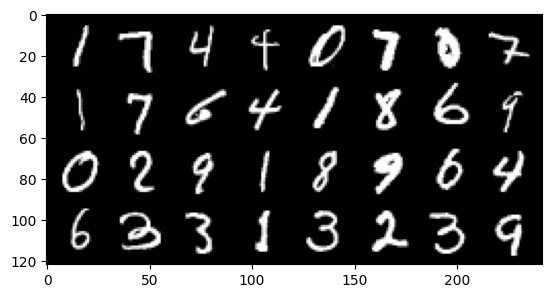

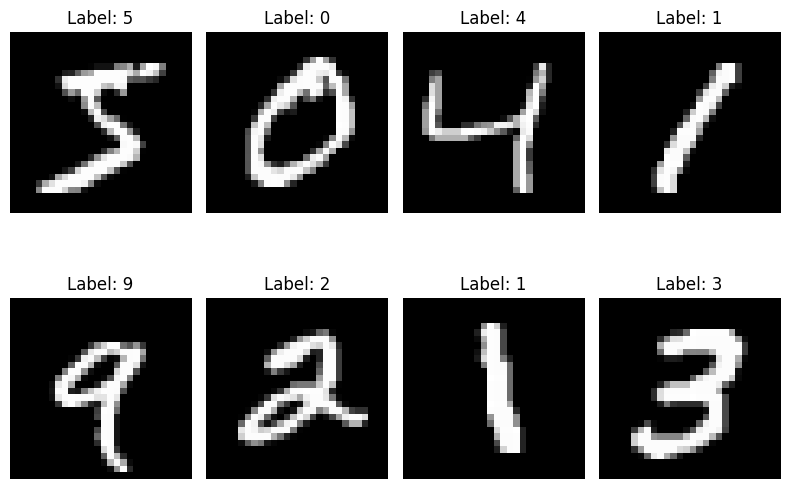

In [137]:
for data in train_loader:
    img, label = data
    plt.imshow(torchvision.utils.make_grid(img, normalize=True).permute(1,2,0))
    plt.show()
    break

def data_plot(num, dataloader):
    rows = (num + 3) // 4  # 필요한 행의 개수 계산
    cols = min(num, 4)  # 한 행에 플롯할 최대 개수 (최대 4개)

    fig, axes = plt.subplots(rows, cols, figsize=(8, rows * 3))

    for i in range(num):
        row = i // cols
        col = i % cols

        image, label = dataloader.dataset[i]
        axes[row, col].imshow(image.squeeze(), cmap='gray')
        axes[row, col].set_title(f"Label: {label}")
        axes[row, col].axis('off')

    # 남는 빈 서브플롯 제거
    if num < rows * cols:
        for j in range(num, rows * cols):
            row = j // cols
            col = j % cols
            fig.delaxes(axes[row, col])

    plt.tight_layout()
    plt.show()

data_plot(8, train_loader)

## 7. CNN 모델 정의

아래 코드는 CNN(Convolutional Neural Network) 모델을 정의하는 부분입니다.

- `input_channel`: 입력 채널의 개수입니다. (MNIST 데이터셋은 흑백 이미지이므로 1입니다.)
- `conv1_output_channel`: 첫 번째 합성곱 레이어의 출력 채널의 개수입니다.
- `conv2_output_channel`: 두 번째 합성곱 레이어의 출력 채널의 개수입니다.

- `class CNN(nn.Module)`: CNN 모델을 정의하는 클래스입니다.
<details>

    - `def __init__(self)`: 모델의 구조를 초기화합니다.
        - `self.conv1 = nn.Conv2d(input_channel, conv1_output_channel, kernel_size=3, stride=1, padding=1)`: 첫 번째 합성곱 레이어를 정의합니다.
        - `self.conv2 = nn.Conv2d(conv1_output_channel, conv2_output_channel, kernel_size=3, stride=1, padding=1)`: 두 번째 합성곱 레이어를 정의합니다.
        - `self.fc = nn.Linear(7 * 7 * conv2_output_channel, 10)`: 완전 연결 레이어를 정의합니다.
    - `def forward(self, x)`: 입력 데이터가 모델을 통과하는 순전파 연산을 정의합니다.
        - `x = self.conv1(x)`: 첫 번째 합성곱 레이어를 통과시킵니다.
        - `x = F.relu(x)`: ReLU 활성화 함수를 적용합니다.
        - `x = F.max_pool2d(x, kernel_size=2, stride=2)`: 최대 풀링을 수행합니다.
        - `x = self.conv2(x)`: 두 번째 합성곱 레이어를 통과시킵니다.
        - `x = F.relu(x)`: ReLU 활성화 함수를 적용합니다.
        - `x = F.max_pool2d(x, kernel_size=2, stride=2)`: 최대 풀링을 수행합니다.
        - `x = x.view(x.size(0), -1)`: 다차원 텐서를 1차원으로 펼칩니다.
        - `x = self.fc(x)`: 완전 연결 레이어를 통과시킵니다.
        - `x = F.log_softmax(x, dim=1)`: 로그-소프트맥스 함수를 적용하여 예측 확률을 얻습니다.
        - `return x`: 최종 예측 확률을 반환합니다.


In [72]:
input_channel = 1
conv1_output_channel = 16
conv2_output_channel = 32


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(input_channel, conv1_output_channel, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(conv1_output_channel, conv2_output_channel, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(7 * 7 * conv2_output_channel, 10)

    def forward(self, x):
        x = x

        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = F.log_softmax(x, dim=1)
        return x

# CNN 모델 인스턴스 생성
model_cnn = CNN().to(DEVICE)

## 8. 모델 파라미터 정보 및 구조 확인

아래 코드는 모델의 파라미터 정보와 구조를 확인하는 부분입니다.
- `named_parameters()` : 모델의 각 파라미터의 이름과 크기를 출력합니다.
- `named_children()`:  모델의 각 자식 모듈과 이름을 출력합니다.
- `summary()` :  모델의 구조와 요약 정보를 출력합니다.


In [73]:
def showModelInfo(model, input=(28,28)):
    for name, param in model.named_parameters():
        print(name, param.size())
    print()
    print(model.named_children())
    print(summary(model, input, batch_size = 32))

showModelInfo(model_cnn, (1,28,28))

conv1.weight torch.Size([16, 1, 3, 3])
conv1.bias torch.Size([16])
conv2.weight torch.Size([32, 16, 3, 3])
conv2.bias torch.Size([32])
fc.weight torch.Size([10, 1568])
fc.bias torch.Size([10])

<generator object Module.named_children at 0x7f955ca0be60>
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [32, 16, 28, 28]             160
            Conv2d-2           [32, 32, 14, 14]           4,640
            Linear-3                   [32, 10]          15,690
Total params: 20,490
Trainable params: 20,490
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.10
Forward/backward pass size (MB): 4.60
Params size (MB): 0.08
Estimated Total Size (MB): 4.77
----------------------------------------------------------------
None


## 9. 초기화와 Optimizer 함수 정의

아래 코드는 모델의 초기화와 Optimizer 함수를 정의하는 부분입니다.


- `weight_init(m)`: 모델의 가중치를 초기화하는 함수입니다.
- `optimizer`: optimizer는 Adam을 사용하여 모델의 파라미터를 최적화합니다.
- `loss_fn` : 손실함수로는 CrossEntropyLoss를 사용합니다.



In [112]:
def weight_init(m):
    if isinstance(m, nn.Linear):
        init.kaiming_uniform_(m.weight.data)

model_cnn.apply(weight_init)
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

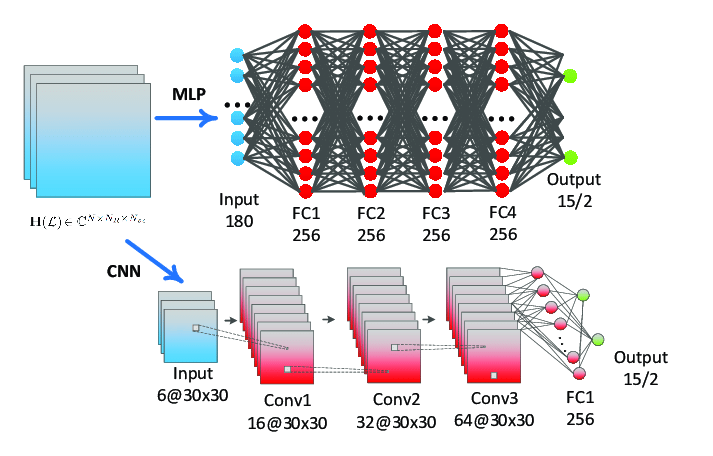

## MLP 모델은 종종 CNN 모델에 비해 Edge device에 전이시키기에 적합합니다. 이 모델은 간단한 구조로 이루어져 있고, 필요한 총 용량이 적습니다. 따라서 제한된 용량을 가진 Edge device에서도 효율적으로 실행될 수 있습니다.CNN을 구현한 과정을 MLP 모델에 적용해봅니다.

##7-1. MLP 모델 정의

아래는 3-Layer MLP 모델의 설계 코드입니다.
- IL_node: 입력 노드 개수로, 입력 이미지의 크기인 28x28 픽셀의 총 개수입니다.
- HL1_node: 첫 번째 은닉층 노드 개수로, 첫 번째 선형 변환 계층의 출력 노드 개수입니다.
- HL2_node: 두 번째 은닉층 노드 개수로, 두 번째 선형 변환 계층의 출력 노드 개수입니다.
- OL_node: 출력 노드 개수로, 분류하고자 하는 클래스의 개수입니다.

MLP 클래스는 nn.Module을 상속받아 모델을 정의합니다. 모델은 __init__ 메서드에서 각 선형 계층을 초기화하고, forward 메서드에서 입력 데이터에 대한 순전파 연산을 수행합니다.

순전파 연산은 다음과 같습니다:

1. 입력 데이터인 x를 2차원으로 변환합니다.
2. 첫 번째 선형 변환 계층을 통과시킵니다. (self.fc1)
3. 활성화 함수로 ReLU를 적용합니다.
4. 두 번째 선형 변환 계층을 통과시킵니다. (self.fc2)
5. 활성화 함수로 ReLU를 적용합니다.
6. 세 번째 선형 변환 계층을 통과시킵니다. (self.fc3)
7. 활성화 함수로 로그-소프트맥스를 적용합니다.
8. 최종적으로 출력된 x는 예측값으로 사용됩니다.

In [119]:
#3-Layer MLP 모델 설계
IL_node=28*28
HL1_node=32
HL2_node=16
OL_node=10

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(IL_node, HL1_node)
        self.fc2 = nn.Linear(HL1_node, HL2_node)
        self.fc3 = nn.Linear(HL2_node, OL_node)

    def forward(self, x):
        x = x.view(-1, 28 * 28)

        x = self.fc1(x)
        x = F.relu(x) # sigmoid(x)

        x = self.fc2(x)
        x = F.relu(x) # sigmoid(x)

        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)

        return x
# 모델 인스턴스 생성
model_MLP = MLP().to(DEVICE)

## 8-1. 모델 파라미터 정보 및 구조 확인

CNN 모델에서와 마찬가지로 MLP 모델의 파라미터 크기와 구조를 확인합니다.

`showModelInfo(모델, 입력)` 함수를 사용합니다.



In [120]:
showModelInfo(model_MLP,(28,28))

fc1.weight torch.Size([32, 784])
fc1.bias torch.Size([32])
fc2.weight torch.Size([16, 32])
fc2.bias torch.Size([16])
fc3.weight torch.Size([10, 16])
fc3.bias torch.Size([10])

<generator object Module.named_children at 0x7f95856b3990>
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [32, 32]          25,120
            Linear-2                   [32, 16]             528
            Linear-3                   [32, 10]             170
Total params: 25,818
Trainable params: 25,818
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.10
Forward/backward pass size (MB): 0.01
Params size (MB): 0.10
Estimated Total Size (MB): 0.21
----------------------------------------------------------------
None


## 9-1. 초기화와 Optimizer 함수 정의

아래 코드는 모델의 초기화와 Optimizer 함수를 정의하는 부분입니다.

In [121]:
model_MLP.apply(weight_init)
optimizer = torch.optim.Adam(model_MLP.parameters(), lr=0.005)
loss_fn = nn.CrossEntropyLoss()

## 10. 학습 함수 정의

아래 코드는 모델을 학습하기 위한 `train` 함수를 정의하는 부분입니다.

**`train` 함수는 `model, train_loader, optimizer, log_interval` 인자로 받아 모델을 학습하는 함수입니다.**

**함수 내부에서는 모델을 학습 모드로 설정하여, 배치단위로 학습을 수행합니다. 각 배치마다 이미지와 라벨을 사용중인 `DEVICE`로 로드하고 옵티마이저를 초기화한 후, 모델의 출력을 계산하여 정확도와 손실을 계산합니다. 그리고 역전파를 수행하여 모델의 가중치를 업데이트합니다.**

**마지막으로, 전체 데이터에 대한 평균 손실과 정확도를 계산하여 반환합니다.**



- `train(model, train_loader, optimizer, log_interval)`: 모델을 학습하는 함수입니다.
  - `model`: 학습할 모델
  - `train_loader`: 학습 데이터로 구성된 데이터로더
  - `optimizer`: 최적화를 담당하는 옵티마이저
  - `log_interval`: 로그를 출력할 주기
  - `show_log`: 로그를 출력할지 여부를 결정하는 플래그 (기본값: False)

    <details>
    <summary> 자세히 </summary>

    - `model.train()`: 모델을 학습 모드로 설정합니다.
    - `optimizer.zero_grad()`: 옵티마이저의 변화도를 초기화합니다.
    - `image.to(DEVICE)`, `label.to(DEVICE)`: 이미지와 라벨을 학습 장치로 이동시킵니다.
    - `output = model(image)`: 모델에 이미지를 입력하여 출력을 계산합니다.
    - `prediction = output.max(1, keepdim=True)[1]`: 출력에서 가장 큰 값을 가진 클래스를 예측값으로 선택합니다.
    - `correct += prediction.eq(label.view_as(prediction)).sum().item()`: 정확하게 예측한 개수를 누적합니다.
    - `loss = loss_fn(output, label)`: 출력과 라벨을 비교하여 손실을 계산합니다.
    - `train_loss += loss`: 배치 손실을 누적합니다.
    - `loss.backward()`: 손실에 대한 변화도를 계산합니다.
    - `optimizer.step()`: 옵티마이저를 사용하여 모델의 가중치를 업데이트합니다.
    - `train_loss /= len(train_loader.dataset)`: 전체 데이터에 대한 평균 손실을 계산합니다.
    - `train_accuracy = 100. * correct / len(train_loader.dataset)`: 전체 데이터에 대한 정확도를 계산합니다.
    - `return train_loss, train_accuracy`: 학습 결과인 평균 손실과 정확도를 반환합니다.</details>

In [122]:
def train(model, train_loader, optimizer, log_interval, show_log = False):
    model.train()
    train_loss = 0
    correct = 0
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()

        output = model(image)
        prediction = output.max(1, keepdim=True)[1]
        correct += prediction.eq(label.view_as(prediction)).sum().item()

        loss = loss_fn(output, label)
        train_loss += loss
        loss.backward()
        optimizer.step()
        # 주기마다 로그 출력
        if batch_idx % log_interval == 0 and show_log == True:
            current_loss = loss.item()
            processed_data = batch_idx * len(image)
            total_data = len(train_loader.dataset)
            print(f'Train Epoch: {EPOCHS+1} [{processed_data}/{total_data} '
                  f'({100. * batch_idx / len(train_loader):.2f}%)]\tLoss: {current_loss:.6f}')
    train_loss /= len(train_loader.dataset)
    train_accuracy = 100. * correct / len(train_loader.dataset)
    return train_loss, train_accuracy

## 11. 평가 함수 정의

아래 코드는 모델을 평가하기 위한 `evaluate` 함수를 정의하는 부분입니다.

- `evaluate(model, test_loader)`: 모델을 평가하는 함수입니다.
  - `model`: 평가할 모델
  - `test_loader`: 평가 데이터로 구성된 데이터로더
    <details>

    - `model.eval()`: 모델을 평가 모드로 설정합니다.
    - `test_loss = 0`, `correct = 0`: 평가 손실과 정확한 예측 수를 초기화합니다.
    - `with torch.no_grad():`: 그래디언트 계산을 비활성화합니다.
    - `for image, label in test_loader:`: 평가 데이터로부터 배치 단위로 데이터를 가져옵니다.
    - `image.to(DEVICE)`, `label.to(DEVICE)`: 이미지와 라벨을 평가 장치로 이동시킵니다.
    - `output = model(image)`: 모델에 이미지를 입력하여 출력을 계산합니다.
    - `test_loss += loss_fn(output, label).item()`: 손실 함수를 사용하여 평가 손실을 누적합니다.
    - `prediction = output.max(1, keepdim=True)[1]`: 출력에서 가장 큰 값을 가진 클래스를 예측값으로 선택합니다.
    - `correct += prediction.eq(label.view_as(prediction)).sum().item()`: 정확하게 예측한 개수를 누적합니다.
    - `test_loss /= len(test_loader.dataset)`: 전체 데이터에 대한 평균 평가 손실을 계산합니다.
    - `test_accuracy = 100. * correct / len(test_loader.dataset)`: 전체 데이터에 대한 정확도를 계산합니다.
    - `return test_loss, test_accuracy`: 평가 결과인 평균 평가 손실과 정확도를 반환합니다.


In [123]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += loss_fn(output, label).item()
            prediction = output.max(1, keepdim=True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

## 12. 학습 및 결과 저장

아래 코드는 모델을 학습하고 결과를 저장하는 부분입니다.
모델을 학습하고, Edge Device에서 추론 가능하도록 모델의 가중치(`W`)와 편향(`b`)을 추출하여 .h 헤더파일로 저장합니다.

1. MLP 모델을 정의하고 초기화합니다.
2. 주어진 에폭 수만큼 모델을 학습하고, 학습 및 평가 손실과 정확도를 계산합니다.
3. 최고 정확도가 갱신될 때마다 모델의 상태를 저장하고, 가중치와 편향 값을 추출하여 파일로 저장합니다.
    <details>

    - `for Epoch in range(1, EPOCHS + 1):`: 주어진 에폭 수만큼 반복합니다.
    - `train_loss, train_accuracy = train(model, train_loader, optimizer, log_interval=100)`: 모델을 학습하고 학습 손실과 정확도를 계산합니다.
    - `test_loss, test_accuracy = evaluate(model, test_loader)`: 모델을 평가하고 평가 손실과 정확도를 계산합니다.
    - `train_loss_values.append(torch.tensor(train_loss, device='cpu'))`, `train_acc_values.append(train_accuracy)`: 학습 손실과 정확도를 리스트에 저장합니다.
    - `test_loss_values.append(test_loss)`, `test_acc_values.append(test_accuracy)`: 평가 손실과 정확도를 리스트에 저장합니다.
    - `print("[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} %".format(Epoch, test_loss, test_accuracy))`: 현재 에폭의 평가 결과를 출력합니다.
    - `print("[EPOCH: {}], \tTrain Loss: {:.4f}, \tTrain Accuracy: {:.2f} %".format(Epoch, train_loss, train_accuracy))`: 현재 에폭의 학습 결과를 출력합니다.
    - `if test_accuracy > max_test_accuracy:`: 현재 평가 정확도가 최고 정확도보다 높은 경우:
    - `max_test_accuracy = test_accuracy`: 최고 정확도를 업데이트합니다.
    - `PATH = "MLP_"+str(HL1_node)+"_"+str(HL2_node)+"_"+acc+"_"+str(Epoch)+".pt"`: 모델의 상태를 저장할 경로를 설정합니다.
    - `torch.save(model.state_dict(), PATH)`: 모델의 상태를 저장합니다.
    - `model_verb_cpu = model.eval()`, `od1 = model_verb_cpu.state_dict()`, `od1 = OrderedDict({k: od1[k].detach().cpu().tolist() for k in od1})`, `od1 = json.dumps(od1)`: 모델의 상태를 CPU로 이동시키고 딕셔너리로 변환합니다.
    - `w1 = str(od1.split('fc1.weight": [[')[1]).split("]]")[0]`, `w1 = w1.replace('[', '{')`, `w1 = w1.replace(']', '}')`, `b1 = str(od1.split('fc1.bias": [')[1]).split(']')[0]`, `w2 = str(od1.split('fc2.weight": [[')[1]).split("]]")[0]`, `w2 = w2.replace('[', '{')`, `w2 = w2.replace(']', '}')`, `b2 = str(od1.split('fc2.bias": [')[1]).split(']')[0]`, `w3 = str(od1.split('fc3.weight": [[')[1]).split("]]")[0]`, `w3 = w3.replace('[', '{')`, `w3 = w3.replace(']', '}')`, `b3 = str(od1.split('fc3.bias": [')[1]).split(']')[0]`: 가중치와 편향 값을 추출합니다.
    - `with open("MLP_"+str(HL1_node)+"_"+str(HL2_node)+"_"+acc+"_"+str(Epoch)+".h", 'w') as outfile:`: 파일을 열고 생성합니다.
    - `outfile.write(w1_name)`, `outfile.write(w1)`, `outfile.write("} };\n")`, `outfile.write(b1_name)`, `outfile.write(b1)`, `outfile.write("};\n")`, `outfile.write(w2_name)`, `outfile.write(w2)`, `outfile.write("} };\n")`, `outfile.write(b2_name)`, `outfile.write(b2)`, `outfile.write("};\n")`, `outfile.write(w3_name)`, `outfile.write(w3)`, `outfile.write("} };\n")`, `outfile.write(b3_name)`, `outfile.write(b3)`, `outfile.write("};")`: 가중치와 편향 값을 파일에 저장합니다.


In [124]:
IL_node=28*28
HL1_node=32
HL2_node=16
OL_node=10

max_test_accuracy=0
w1_name="float w1["+str(HL1_node)+"]["+str(IL_node)+"] = { { "
b1_name="float b1["+str(HL1_node)+"] = { "
w2_name="float w2["+str(HL2_node)+"]["+str(HL1_node)+"] = { { "
b2_name="float b2["+str(HL2_node)+"] = { "
w3_name="float w3["+str(OL_node)+"]["+str(HL2_node)+"] = { { "
b3_name="float b3["+str(OL_node)+"] = { "

# 모델 학습 중 손실 기록을 저장하는 리스트
train_loss_values = []
test_loss_values = []
# 모델 학습 중 정확도 기록을 저장하는 리스트
train_acc_values = []
test_acc_values = []

#MLP 모델 사용
model = model_MLP

for Epoch in range(1, EPOCHS + 1):
    train_loss, train_accuracy = train(model, train_loader, optimizer, log_interval=100)
    test_loss, test_accuracy = evaluate(model, test_loader)
    train_loss_values.append(torch.tensor(train_loss, device = 'cpu'))
    train_acc_values.append(train_accuracy)

    test_loss_values.append(test_loss)
    test_acc_values.append(test_accuracy)
    print("[EPOCH: {}], \tTrain Loss: {:.4f}, \tTrain Accuracy: {:.2f} %".format(
        Epoch, train_loss, train_accuracy
    ))
    print("[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} %".format(
        Epoch, test_loss, test_accuracy
    ))
    if test_accuracy > max_test_accuracy:
      max_test_accuracy = test_accuracy
      acc = str(max_test_accuracy)
      PATH = "MLP_"+str(HL1_node)+"_"+str(HL2_node)+"_"+acc+"_"+str(Epoch)+".pt"
      torch.save(model.state_dict(), PATH)
      model_verb_cpu = model.eval()
      od1 = model_verb_cpu.state_dict()
      od1 = OrderedDict({k: od1[k].detach().cpu().tolist() for k in od1})
      od1 = json.dumps(od1)
      w1=str(od1.split('fc1.weight": [[')[1]).split("]]")[0]
      w1=w1.replace('[','{')
      w1=w1.replace(']','}')
      b1=str(od1.split('fc1.bias": [')[1]).split(']')[0]
      w2=str(od1.split('fc2.weight": [[')[1]).split("]]")[0]
      w2=w2.replace('[','{')
      w2=w2.replace(']','}')
      b2=str(od1.split('fc2.bias": [')[1]).split(']')[0]
      w3=str(od1.split('fc3.weight": [[')[1]).split("]]")[0]
      w3=w3.replace('[','{')
      w3=w3.replace(']','}')
      b3=str(od1.split('fc3.bias": [')[1]).split(']')[0]
      with open("MLP_"+str(HL1_node)+"_"+str(HL2_node)+"_"+acc+"_"+str(Epoch)+".h", 'w') as outfile:
          outfile.write(w1_name)
          outfile.write(w1)
          outfile.write("} };\n")
          outfile.write(b1_name)
          outfile.write(b1)
          outfile.write("};\n")
          outfile.write(w2_name)
          outfile.write(w2)
          outfile.write("} };\n")
          outfile.write(b2_name)
          outfile.write(b2)
          outfile.write("};\n")
          outfile.write(w3_name)
          outfile.write(w3)
          outfile.write("} };\n")
          outfile.write(b3_name)
          outfile.write(b3)
          outfile.write("};")

<ipython-input-124-81223bb17dd3>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_loss_values.append(torch.tensor(train_loss, device = 'cpu'))


[EPOCH: 1], 	Train Loss: 0.0090, 	Train Accuracy: 91.48 %
[EPOCH: 1], 	Test Loss: 0.0058, 	Test Accuracy: 94.30 %
[EPOCH: 2], 	Train Loss: 0.0050, 	Train Accuracy: 95.34 %
[EPOCH: 2], 	Test Loss: 0.0045, 	Test Accuracy: 95.78 %
[EPOCH: 3], 	Train Loss: 0.0042, 	Train Accuracy: 96.00 %
[EPOCH: 3], 	Test Loss: 0.0054, 	Test Accuracy: 94.88 %
[EPOCH: 4], 	Train Loss: 0.0038, 	Train Accuracy: 96.33 %
[EPOCH: 4], 	Test Loss: 0.0045, 	Test Accuracy: 95.92 %
[EPOCH: 5], 	Train Loss: 0.0034, 	Train Accuracy: 96.83 %
[EPOCH: 5], 	Test Loss: 0.0046, 	Test Accuracy: 96.16 %
[EPOCH: 6], 	Train Loss: 0.0032, 	Train Accuracy: 96.86 %
[EPOCH: 6], 	Test Loss: 0.0041, 	Test Accuracy: 96.56 %
[EPOCH: 7], 	Train Loss: 0.0030, 	Train Accuracy: 97.10 %
[EPOCH: 7], 	Test Loss: 0.0048, 	Test Accuracy: 96.02 %
[EPOCH: 8], 	Train Loss: 0.0029, 	Train Accuracy: 97.14 %
[EPOCH: 8], 	Test Loss: 0.0040, 	Test Accuracy: 96.59 %
[EPOCH: 9], 	Train Loss: 0.0027, 	Train Accuracy: 97.34 %
[EPOCH: 9], 	Test Loss: 0.0046

## 13. 손실 및 정확도 시각화 함수 정의

아래 코드는 학습 및 테스트 손실, 정확도를 시각화하는 함수 `rst_plot`를 정의하는 부분입니다.

- `rst_plot(value1, value2, title)`: 손실 또는 정확도 값을 입력받아 시각화하는 함수입니다.
  - `value1`: 첫 번째 값 (예: 학습 손실)
  - `value2`: 두 번째 값 (예: 테스트 손실)
  - `title`: 그래프 제목

- `plt.plot(value1, label='Training')`, `plt.plot(value2, label='Test')`: 두 개의 값에 대한 그래프를 그립니다.
- `plt.xlabel('Epoch')`, `plt.ylabel('Values')`: x축과 y축 레이블을 설정합니다.
- `plt.title(title)`: 그래프의 제목을 설정합니다.
- `plt.legend()`: 범례를 표시합니다.
- `plt.show()`: 그래프를 화면에 출력합니다.


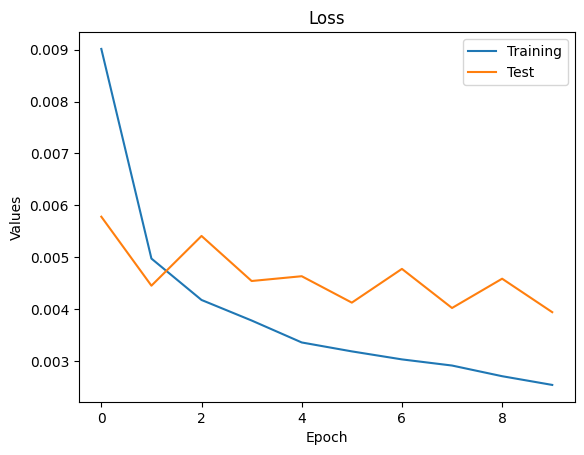

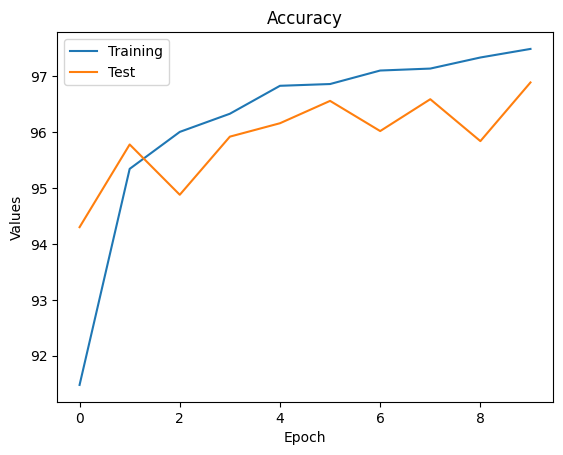

In [125]:
def rst_plot(value1, value2, title):
    plt.plot(value1, label='Training')
    plt.plot(value2, label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Values')
    plt.title(title)
    plt.legend()
    plt.show()

rst_plot(train_loss_values, test_loss_values, 'Loss')

rst_plot(train_acc_values, test_acc_values,'Accuracy')


##14. 학습 결과를 시각화하여 확인해봅니다.

아래 코드는 모델의 예측 결과를 시각화하는 `visualize_predictions` 함수를 정의하는 부분입니다.

- `visualize_predictions(model, test_loader, num_images)`: 모델의 예측 결과를 시각화하는 함수입니다.
  - `model`: 예측에 사용할 모델
  - `test_loader`: 테스트 데이터로 구성된 데이터로더
  - `num_images`: 시각화할 이미지 개수

<details>

- `model.eval()`: 모델을 평가 모드로 설정합니다.
- `with torch.no_grad():`: 그래디언트 계산을 비활성화합니다.
- `for i, (image, label) in enumerate(test_loader):`: 테스트 데이터로부터 이미지와 라벨을 가져옵니다.
- `if i >= num_images: break`: 지정한 이미지 개수에 도달하면 반복문을 종료합니다.
- `image.to(DEVICE)`: 이미지를 학습 장치로 이동시킵니다.
- `output = model(image)`: 모델에 이미지를 입력하여 예측 결과를 계산합니다.
- `_, predicted = torch.max(output, dim=1)`: 예측 결과에서 가장 큰 값을 가진 클래스를 선택합니다.
- `image = image.squeeze().cpu()`, `predicted = predicted.cpu().numpy()`, `label = label.numpy()`: 이미지, 예측값, 실제 라벨을 CPU로 이동시킵니다.
- `plt.imshow(image, cmap='gray')`: 이미지를 그레이스케일로 표시합니다.
- `plt.title(f"Label: {label[0]}, Predicted: {predicted[0]}")`: 제목에 실제 라벨과 예측값을 표시합니다.
- `plt.axis('off')`: 축을 표시하지 않습니다.
- `plt.show()`: 이미지를 화면에 출력합니다.


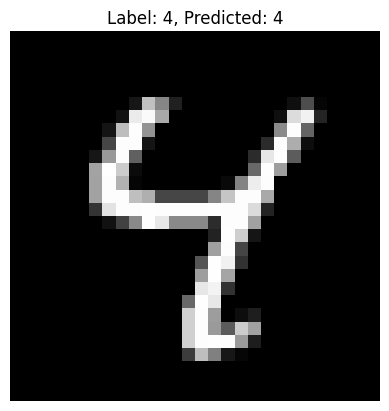

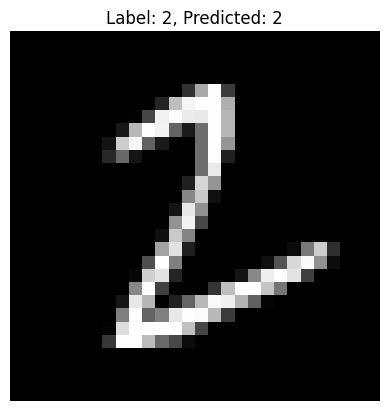

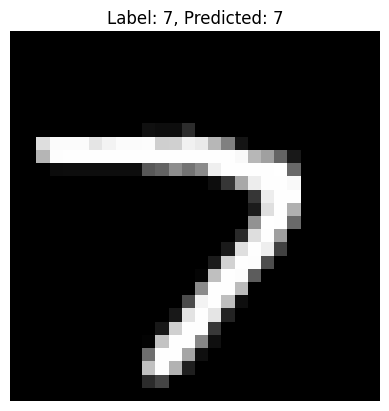

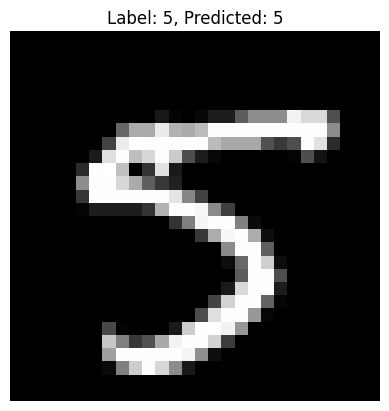

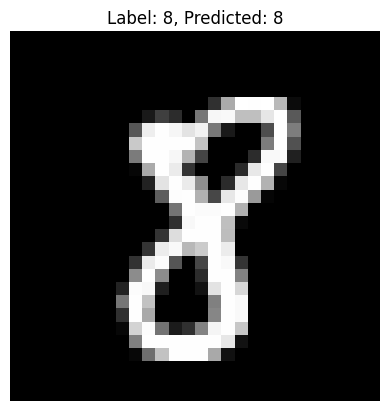

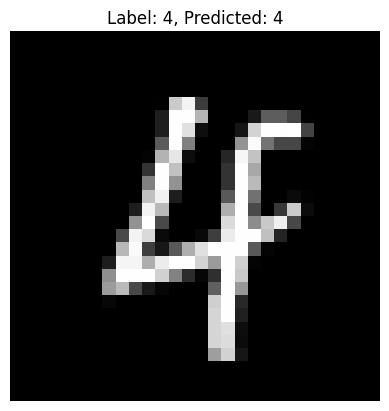

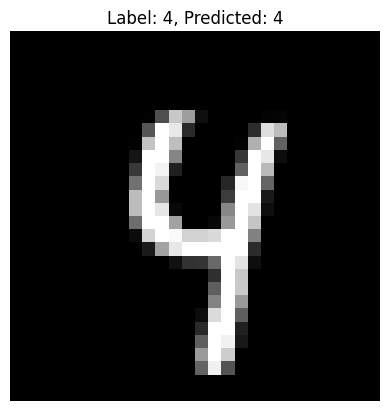

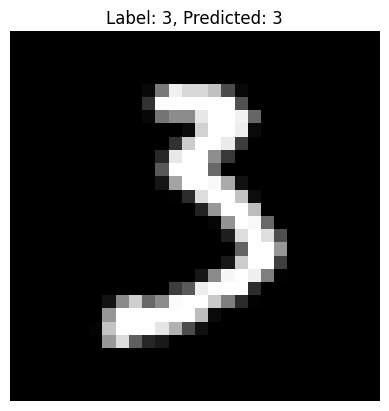

In [171]:
def visualize_predictions(model, test_loader, num_images):
    model.eval()
    sample_idx = np.random.randint(0,BATCH_SIZE)
    with torch.no_grad():
        for i, (image, label) in enumerate(test_loader):
            if i >= num_images:
                break
            image = image.to(DEVICE)
            output = model(image)
            _, predicted = torch.max(output, dim=1)

            image = image.squeeze().cpu()
            predicted = predicted.cpu().numpy()
            label = label.numpy()

            plt.imshow(image[sample_idx], cmap='gray')
            plt.title(f"Label: {label[sample_idx]}, Predicted: {predicted[sample_idx]}")
            plt.axis('off')
            plt.show()

# 테스트 데이터 N장 시각화
N = 8  # 시각화할 이미지 개수
visualize_predictions(model_MLP, test_loader, N)


1
